1) Deep Learning - Use this dataset to detect age: https://www.kaggle.com/train_dfsets/arashnic/faces-age-detection-train_dfset. Build two deep models - one from scratch and the other using a pretrained model to obtain embeddings of the given data. Compare the performances.

> Indented block



Model From Scratch

Fetching the dataset from my gdrive

In [1]:
import pandas as pd
import tensorflow as tf
import glob
import os
from google.colab import drive
drive.mount('/content/gdrive/')
!unzip gdrive/MyDrive/my_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/4047.jpg          
  inflating: Train/4049.jpg          
  inflating: Train/405.jpg           
  inflating: Train/4051.jpg          
  inflating: Train/4052.jpg          
  inflating: Train/4053.jpg          
  inflating: Train/4055.jpg          
  inflating: Train/4056.jpg          
  inflating: Train/4057.jpg          
  inflating: Train/4058.jpg          
  inflating: Train/4059.jpg          
  inflating: Train/406.jpg           
  inflating: Train/4060.jpg          
  inflating: Train/4061.jpg          
  inflating: Train/4062.jpg          
  inflating: Train/4065.jpg          
  inflating: Train/4066.jpg          
  inflating: Train/4068.jpg          
  inflating: Train/4069.jpg          
  inflating: Train/407.jpg           
  inflating: Train/4070.jpg          
  inflating: Train/4072.jpg          
  inflating: Train/4073.jpg          
  inflating: Train/4076.jpg          
  inflating: Train/4078.jpg          

Reading the training dataset into a df

In [3]:
train_df = pd.read_csv('train.csv')
train_df.count()

ID       19906
Class    19906
dtype: int64

In [4]:
train_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


Converting Categorical Decision column into numerical

In [5]:
train_df['Class'].unique()

array(['MIDDLE', 'YOUNG', 'OLD'], dtype=object)

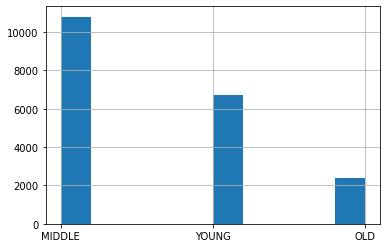

In [6]:
train_df['Class'].hist()

In [7]:
train_df['Class'].replace(['YOUNG', 'MIDDLE','OLD'], [0, 1, 2], inplace=True)
train_df.head()


,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1
3,16496.jpg,0
4,4487.jpg,1


In [8]:
# Unique Age Class columns
train_df['Class'].unique()

array([1, 0, 2])

In [9]:
#Count of Age Class Columns
train_df['Class'].value_counts()

1    10804
0     6706
2     2396
Name: Class, dtype: int64

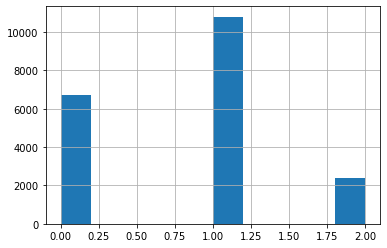

In [10]:
train_df['Class'].hist()

Function to read the images and load

In [11]:
def ReadImage(path,ch = 3, resize=(512,512)):
	"""
	- Path: Image Path
	- CH: channel
	- resize: Resize parametres
	"""
	fpath = tf.io.read_file(path)
	fpath = tf.image.decode_jpeg(fpath, channels=ch)
	fpath = tf.image.convert_image_dtype(fpath, dtype=tf.float32)
	fpath = tf.image.resize(fpath, resize)
	return fpath

def load_data(image_path, label):
    image = ReadImage(image_path, 3, (512,512))
    
    return (image, label)

In [12]:
image = glob.glob('/content/Train/*.jpg')
print(len(image))

labels = []
for i in image:
    _,tail = os.path.split(i)
    label = train_df.loc[train_df['ID'] == tail]['Class'].values[0]
    labels.append(label)
print(len(labels))

19906
19906


Splitting the Image Dataset into train and test splits.

In [13]:
# Train Test Split
train_size = int(0.9*(len(image)))
test_size = int(0.1*(len(image)))

train = tf.data.Dataset.from_tensor_slices((image[:train_size], labels[:train_size]))
test = tf.data.Dataset.from_tensor_slices((image[train_size:], labels[train_size:]))

AUTOTUNE the Training data

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train = (train
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)
print(train)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


AUTOTUNE the Testing data

In [15]:
test = (test
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)
print(test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Building the Model using MobileNetV2

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
deep_model = tf.keras.applications.MobileNetV2(input_shape = (512,512,3,),include_top=False,weights='imagenet')
deep_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                

Adding Layers to the model

In [17]:
deep_model.trainable = False

inputs = tf.keras.Input(shape=(512, 512, 3))
x = preprocess_input(inputs)
x = deep_model(x, training=True)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(3)(x)
deep_model = tf.keras.Model(inputs, outputs)
deep_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 512, 512, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 16, 16, 1280)     2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                              

Compiling the Model

In [18]:
deep_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
!pip install pyyaml h5py 

import os

import tensorflow as tf
from tensorflow import keras

checkpoint_path = "/content/trained_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

os.listdir(checkpoint_dir)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[]

Fitting the Model

In [52]:
model_his = deep_model.fit(train,epochs=4,validation_data=test)

Epoch 1/4
280/280 [==============================] - 3425s 12s/step - loss: 1.5277 - accuracy: 0.4449 - val_loss: 0.9631 - val_accuracy: 0.5404
Epoch 2/4
280/280 [==============================] - 3502s 13s/step - loss: 1.1005 - accuracy: 0.4824 - val_loss: 0.9354 - val_accuracy: 0.5394
Epoch 3/4
280/280 [==============================] - 3561s 13s/step - loss: 1.0163 - accuracy: 0.5034 - val_loss: 0.9373 - val_accuracy: 0.5394
Epoch 4/4
280/280 [==============================] - 3608s 13s/step - loss: 0.9936 - accuracy: 0.5144 - val_loss: 0.9303 - val_accuracy: 0.5394


In [53]:
print(model_his.history['accuracy'])
print(model_his.history['val_accuracy'])

[0.4449343979358673, 0.48238906264305115, 0.5034328699111938, 0.5143734216690063]
[0.5404319167137146, 0.5394273996353149, 0.5394273996353149, 0.5394273996353149]


Accuracy after 4 Epochs

In [54]:
hist_df = pd.DataFrame(model_his.history)
hist_df['epoch'] = model_his.epoch
hist_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
0,1.527652,0.444934,0.963100,0.540432,0
1,1.100522,0.482389,0.935400,0.539427,1
2,1.016309,0.503433,0.937277,0.539427,2
3,0.993625,0.514373,0.930273,0.539427,3


In [61]:
import matplotlib.pyplot as plt
def plot_loss(model):
  plt.plot(model.history['loss'], label='loss')
  plt.plot(model.history['val_loss'], label='val_loss')
  plt.ylim([0.8, 1.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  plt.savefig("Model.png")

Plot to visualize the Training loss and the validation loss

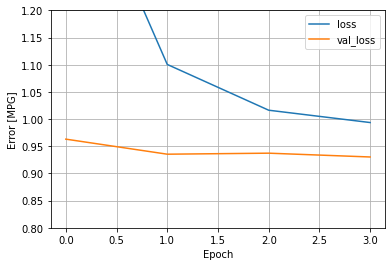

In [62]:
plot_loss(model_his)

In [63]:
pred = deep_model.predict(test)

32/32 [==============================] - 375s 11s/step


In [64]:
print(pred)

[[ 0.59417343  1.5170848  -0.15742147]
 [ 0.6547912   1.4809659  -0.19183838]
 [ 0.6364824   1.5752445  -0.19534981]
 ...
 [ 0.92789906  1.556915   -0.39150423]
 [ 0.7241706   1.3646524  -0.11864734]
 [ 0.8259137   1.4087443  -0.36830503]]


Pre-Trained Model

In [22]:
# preprocess_input = tf.keras.applications.ResNet50.preprocess_input
deep_model1 = tf.keras.applications.ResNet50(input_shape = (512,512,3,),include_top=False,weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


In [23]:
deep_model1.trainable = False

inputs = tf.keras.Input(shape=(512, 512, 3))
x = preprocess_input(inputs)
x = deep_model1(x, training=True)
# x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1000)(x)
x = tf.keras.layers.Dense(600)(x)
x = tf.keras.layers.Dense(600)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(400)(x)
x = tf.keras.layers.Dense(400)(x)
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dense(100)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3)(x)
deep_model1 = tf.keras.Model(inputs, outputs)
deep_model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 512, 512, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 512, 512, 3)      0         
 bda)                                                            
                                                                 
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense_1 (Dense)             (None, 1000)              5242

In [25]:
deep_model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Fitting the model with 1 Epochs

In [26]:
model_his1 = deep_model1.fit(train,epochs=1,validation_data=test)

280/280 [==============================] - 18643s 67s/step - loss: 280.8918 - accuracy: 0.4158 - val_loss: 67.2830 - val_accuracy: 0.5414
